In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor


def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic, critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        original_noise=True,
        action_clipper=[-10., 10.],
        tau_clipper=[0.001, 1.],
        params_logging=False,
        gradient_logging=False,
        batch_size=128,
    )
    return agent

In [34]:
# agent compilation
l = 1.
a = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=100., clipnorm=1.), Adam(lr=0.001, clipnorm=1.) # actorの方は何でもいい
optimizer = [actor_optimizer, critic_optimizer]
a.compile(optimizer=optimizer, metrics=["mse"], action_lr=0.0001, tau_lr=0.001)
a.actor.load_weights('./saved_agent/learned_self_clipped3_actor.h5')

In [49]:
def add_original_noise(state, actor_output, c_u=0.1, c_tau=0.8):
    # 次の状態の行動に対する勾配によってノイズスケールを決める
    hypara = [1,1,10]
    next_state_action_gradient, next_state_tau_gradient = next_state_gradient(state, actor_output[0], actor_output[1], hypara)
    size_of_gu = np.linalg.norm(next_state_action_gradient)
    size_of_gt = np.linalg.norm(next_state_tau_gradient)

    coef_u = c_u / (size_of_gu+c_u)
    coef_tau = c_tau / (0.8*size_of_gt+c_tau)

    action, tau = actor_output
    action += np.random.randn() * coef_u
    tau += np.random.randn() * coef_tau
    return np.array([action, tau, coef_u, coef_tau])

def next_state_gradient(state0, action, tau, hypara):
    # linear system
    m, l, g = hypara
    A = np.array([[0, 1], [(3*g)/(2*l), 0]])
    B = np.array([0, 3/(m*l**2)])
    
    # ∂s'/∂τ
    dsdt = np.dot(np.dot(A, _array_exp(A*tau)), state0) + B*action

    # ∂s'/∂u
    dsdu = np.dot(np.dot(_array_exp(A*tau), np.linalg.inv(A)), B) \
         - np.dot(np.dot(_array_exp(A*tau), np.linalg.inv(A)), np.dot(_array_exp(-A*tau), B))

    return [dsdt, dsdu]

def _array_exp(A):
    v, p = np.linalg.eig(A)
    align = np.array([[v[0], 0],[0, v[1]]])
    exp = np.exp(align)
    out = np.dot(np.dot(p, exp), np.linalg.inv(p))
    return out

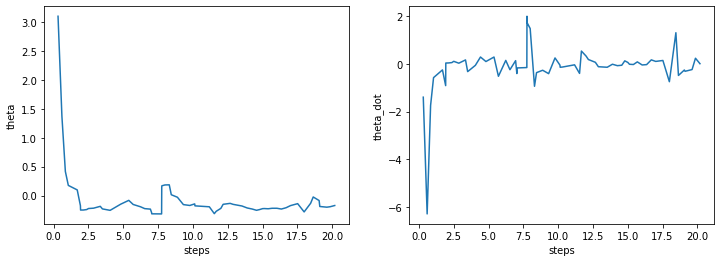

In [52]:
%matplotlib inline
def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2 * np.pi
    th = np.sign(th) * r
    return th

l = 1.
a.training = False
env.reset()
env.set_state(np.array([3.1, -1.4]))
states = []
time_limit = 20
time_log = []
taus = []
acc_time = 0
episode_reward = 0
coefs = []
while True:
    reward = 0
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    
    # noise
    a_agent, tau, coef_u, coef_tau = add_original_noise(x, [a_agent, tau])
    coefs.append([coef_u, coef_tau])
    a_agent = np.clip(a_agent, -10., 10.)
    tau = np.clip(tau, 0.01, 1.)

    
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    if acc_time > time_limit:
        break
states = np.array(states)
coefs = np.array(coefs)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(time_log, states[:,1])
plt.show()

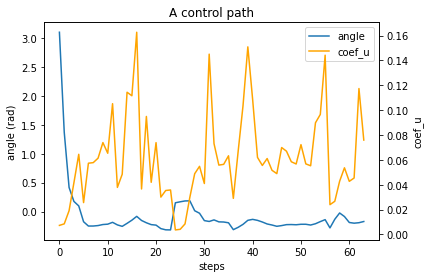

In [53]:
plt.figure()
ax1 = plt.subplot(1,1,1)
ax1.plot(states[:,0], label='angle')
ax2 = ax1.twinx()
ax2.plot(coefs[:,0], color='orange', label='coef_u')
ax1.set_ylabel('angle (rad)')
ax2.set_ylabel('coef_u')
plt.title('A control path')
ax1.set_xlabel('steps')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2)#, loc='upper left')
plt.show()

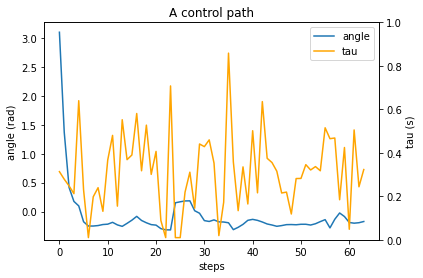

In [54]:
plt.figure()
ax1 = plt.subplot(1,1,1)
ax1.plot(states[:,0], label='angle')
ax2 = ax1.twinx()
ax2.plot(taus, color='orange', label='tau')
ax1.set_ylabel('angle (rad)')
ax2.set_ylabel('tau (s)')
plt.title('A control path')
ax1.set_xlabel('steps')
ax2.set_ylim(0.0,1.)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2)#, loc='upper left')
plt.show()

In [9]:
# 係数決める関数
# 勾配ノルムの定義域 -> その定義域での係数ってどうなっているのかをみる
df = pd.read_csv('./csv/replay_buffer_supervised.csv', index_col=0)
replay_buffer = np.array(df.values)
state0_batch = replay_buffer[:,:2]
action_batch = replay_buffer[:,2:4]
reward_batch = replay_buffer[:,4]
state1_batch = replay_buffer[:,5:7]

In [10]:
hypara = [1,1,10]

dt = []
du = []

for i in range(len(replay_buffer)):
    state = state0_batch[i]
    action = action_batch[i]
    
    dsdt, dsdu = next_state_gradient(state, action[0], action[1], hypara)
    norm_dsdt, norm_dsdu = np.linalg.norm(dsdt), np.linalg.norm(dsdu)
    
    dt.append(norm_dsdt)
    du.append(norm_dsdu)

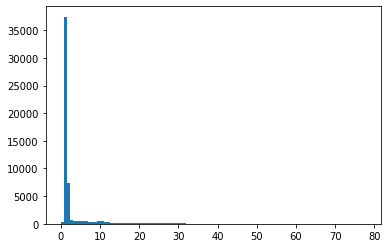

3.3768012835939727 28.855237334448095


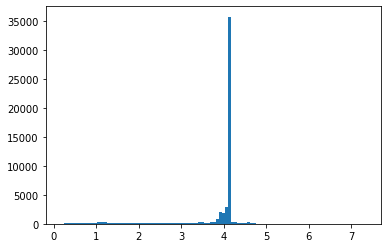

3.800051533102268 0.7694109026970412


In [11]:
plt.hist(dt, bins=100)
plt.show()
print(np.mean(dt), np.var(dt))
plt.hist(du, bins=100)
plt.show()
print(np.mean(du), np.var(du))

In [55]:
ys, ys2 = [], []
for x in range(100):
    y = 0.1 / (x+0.1)
    ys.append(y)
    y = 0.8 / (x+0.8)
    ys2.append(y)

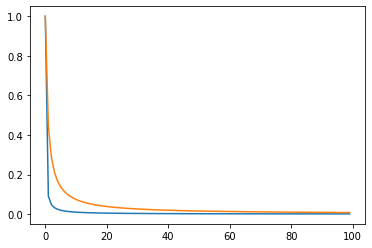

In [56]:
plt.plot(range(100), ys)
plt.plot(range(100), ys2)